In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, f1_score

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [31]:
RANDOM_STATE 

# Prepare data

## Import data

In [441]:
data = pd.read_csv(r'train.csv')
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [426]:
target = 'Survived'

## Prepare data

In [443]:
def add_features(df):
    df_engineered = df.copy()
    df_engineered['location'] = df_engineered['Cabin'].fillna('Unknown').astype(str).str[0]
    # Identify larger families
    df_engineered['FamilySize'] = df_engineered['SibSp'] + df_engineered['Parch'] + 1  # +1 to include self
    # Passengers travelling alone
    df_engineered['IsAlone'] = (df_engineered['FamilySize'] == 1).astype(int)
    # Title correlates with survival
    df_engineered['Title'] = df_engineered['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
    
    title_map = {
        'Miss': 'Miss', 'Master': 'Master', 'Mrs': 'Mrs', 'Mr': 'Mr',
        'Dr': 'Rare', 'Rev': 'Rare', 'Col': 'Rare', 'Major': 'Rare',
        'Mlle': 'Miss', 'Mme': 'Mrs', 'Countess': 'Rare', 'Jonkheer': 'Rare'
    }
    df_engineered['Title'] = df_engineered['Title'].map(title_map).fillna('Rare')
    df_engineered['TicketPrefix'] = df_engineered['Ticket'].apply(lambda x: x.split()[0] if x.split()[0].isalpha() else 'Unknown')
    df_engineered['FarePerPerson'] = df_engineered['Fare'] / df_engineered['FamilySize']
    df_engineered['HasCabin'] = df_engineered['Cabin'].apply(lambda x: 0 if x == 'Unknown' else 1)
    
    
    return df_engineered

In [428]:
def impute_age(df):
    df_imputed = df.copy()
    
    # Fit a regression to predict age
    age_data = df_imputed[['Age', 'Pclass', 'Fare', 'Title', 'FamilySize']].copy()
    age_data = pd.get_dummies(age_data, columns=['Title'], drop_first=True) 
    
    # Train a model only on known ages
    train_data = age_data[age_data['Age'].notnull()]
    test_data = age_data[age_data['Age'].isnull()]
    
    rf_age = RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE)
    rf_age.fit(train_data.drop(columns=['Age']), train_data['Age'])
    
    # Predict missing ages
    df_imputed.loc[df_imputed['Age'].isnull(), 'Age'] = rf_age.predict(test_data.drop(columns=['Age']))
    return df_imputed

In [429]:
def encode_cat(df):
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns
    numerical_cols = [col for col in df.columns if col not in categorical_cols]
    # One-hot encode only the categorical columns
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
    return df_encoded

In [430]:
def scale_data(df):
    # Identify numerical columns (excluding categorical)
    binary_cols = [col for col in df.columns if df[col].nunique() == 2]
    continuous_cols = [col for col in df.select_dtypes(include=['number']).columns if col not in binary_cols]

    # Create a copy to scale only numerical columns
    df_scaled = df.copy()
    
    # Apply scaling only to continuous numerical features
    scaler = StandardScaler()
    df_scaled[continuous_cols] = scaler.fit_transform(df_scaled[continuous_cols])
    
    return df_scaled

In [434]:
def prep_data(df, dropped_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']):
    df_prep = add_features(df)
    df_prep.drop(columns=dropped_cols, inplace=True)
    df_prep = impute_age(df_prep)
    df_prep['AgeGroup'] = pd.cut(df_prep['Age'], bins=[0, 12, 18, 35, 50, 80], labels=['Child', 'Teen', 'Adult', 'Mid-Age', 'Senior'])
    df_prep = encode_cat(df_prep)
    df_prep = scale_data(df_prep)
    df_prep.fillna(0, inplace=True)
    return df_prep

In [444]:
data = prep_data(data)
data.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,FarePerPerson,HasCabin,...,TicketPrefix_Fa,TicketPrefix_LINE,TicketPrefix_PC,TicketPrefix_PP,TicketPrefix_SC,TicketPrefix_Unknown,AgeGroup_Teen,AgeGroup_Adult,AgeGroup_Mid-Age,AgeGroup_Senior
0,0,0.827377,-0.559147,0.432793,-0.473674,-0.502445,0.059160,0,-0.454798,0.0,...,False,False,False,False,False,True,False,True,False,False
1,1,-1.566107,0.601795,0.432793,-0.473674,0.786845,0.059160,0,0.438994,0.0,...,False,False,True,False,False,False,False,False,True,False
2,1,0.827377,-0.268911,-0.474545,-0.473674,-0.488854,-0.560975,1,-0.334757,0.0,...,False,False,False,False,False,True,False,True,False,False
3,1,-1.566107,0.384118,0.432793,-0.473674,0.420730,0.059160,0,0.185187,0.0,...,False,False,False,False,False,True,False,True,False,False
4,0,0.827377,0.384118,-0.474545,-0.473674,-0.486337,-0.560975,1,-0.331267,0.0,...,False,False,False,False,False,True,False,True,False,False


## Prepare data

In [391]:
X = data.drop(columns='Survived')
y = data['Survived']

In [392]:
X_train, X_test, y_train, y_test = train_test_split(X , y,test_size=0.3, random_state = RANDOM_STATE, stratify=y) 

# Find best model

## Run different classifications

In [366]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1 Score': f1_score(y_test, y_pred, average='weighted')
    }
    
    return metrics

In [367]:
def train_and_compare_models(X_train, y_train, X_test, y_test, random_state):
    """
    Train multiple models, evaluate them, and select the best one.
    """
    models = [
        {'name': 'Logistic Regression (Default)', 'model': LogisticRegression(solver='lbfgs', max_iter=500)},
        {'name': 'Logistic Regression (L1)', 'model': LogisticRegression(penalty='l1', solver='liblinear', max_iter=500)},
        {'name': 'Logistic Regression (L2)', 'model': LogisticRegression(penalty='l2', solver='lbfgs', max_iter=500)},
        {'name': 'Random Forest', 'model': RandomForestClassifier(n_estimators=100, random_state=random_state)},
        {'name': 'Support Vector Machine (SVM)', 'model': SVC(kernel='linear', probability=True)},
        {'name': 'Gradient Boosting', 'model': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=random_state)},
        {'name': 'K-Nearest Neighbors (KNN)', 'model': KNeighborsClassifier(n_neighbors=5)}
    ]

    results = []
    best_model = None
    best_score = 0

    for config in models:
        model = config['model']
        model.fit(X_train, y_train)
        
        # Evaluate the model
        metrics = evaluate_model(model, X_test, y_test)
        metrics['Model'] = config['name']
        
        results.append(metrics)
        
        # Select the best model based on F1-score
        if metrics['F1 Score'] > best_score:
            best_score = metrics['F1 Score']
            best_model = model
    
    # Convert results to DataFrame for better visualization
    df_results = pd.DataFrame(results)

    return best_model, df_results

In [393]:
best_model, model_results = train_and_compare_models(X_train, y_train, X_test, y_test, RANDOM_STATE)
model_results

,Accuracy,Precision,Recall,F1 Score,Model
0,0.820225,0.820225,0.820225,0.820225,Logistic Regression (Default)
1,0.823970,0.824317,0.823970,0.824132,Logistic Regression (L1)
2,0.820225,0.820225,0.820225,0.820225,Logistic Regression (L2)
3,0.820225,0.819623,0.820225,0.819876,Random Forest
4,0.838951,0.837794,0.838951,0.837763,Support Vector Machine (SVM)
5,0.842697,0.841831,0.842697,0.842066,Gradient Boosting
6,0.805243,0.803427,0.805243,0.803574,K-Nearest Neighbors (KNN)


## Run a neural network

In [394]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [395]:
from sklearn.utils.class_weight import compute_class_weight

In [396]:
from tensorflow.keras.optimizers import SGD

In [397]:
def train_neural_network(X_train, y_train, X_test, y_test, epochs=50, batch_size=32):

    input_shape = X_train.shape[1]  # Number of features

    # Define the neural network model
    model = Sequential([
        keras.Input(shape=(input_shape,)),
        Dense(128, activation='relu'),  # More neurons
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])


    # Compile the model
    model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
              loss='binary_crossentropy',
              metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0, validation_data=(X_test, y_test))

    # Make predictions (convert probabilities to binary predictions)
    y_pred_prob = model.predict(X_test)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Evaluate performance
    metrics = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }

    print(f"\nNeural Network Performance:\n{metrics}")

    return model, metrics


In [398]:
nn_model, nn_results = train_neural_network(X_train, y_train, X_test, y_test)
nn_results

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Neural Network Performance:
{'Accuracy': 0.8164794007490637, 'Precision': 0.7623762376237624, 'Recall': 0.7549019607843137, 'F1 Score': 0.7586206896551724}


{'Accuracy': 0.8164794007490637,
 'Precision': 0.7623762376237624,
 'Recall': 0.7549019607843137,
 'F1 Score': 0.7586206896551724}

## Improve best model

In [309]:
# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # More trees improve learning
    'learning_rate': [0.01, 0.05, 0.1],  # Lower LR avoids overfitting
    'max_depth': [3, 5, 7],  # Deeper trees capture more patterns
    'min_samples_split': [2, 5, 10],  # Prevents overfitting
    'subsample': [0.7, 0.85, 1.0]  # Reduces overfitting
}

In [310]:
# Train the first Gradient Boosting model
gb_model = GradientBoostingClassifier(random_state=RANDOM_STATE)
# Perform Grid Search
grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Get the best model
best_gb_model = grid_search.best_estimator_

# Print best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 3, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.7}


In [311]:
# Train with the best parameters found
best_gb_model.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.05, n_estimators=200,
                           random_state=17, subsample=0.7)

In [312]:
evaluate_model(best_gb_model, X_train, y_train)

{'Accuracy': 0.9228295819935691,
 'Precision': 0.9232320566125817,
 'Recall': 0.9228295819935691,
 'F1 Score': 0.9221967634719658}

In [313]:
evaluate_model(best_gb_model, X_test, y_test)

{'Accuracy': 0.8539325842696629,
 'Precision': 0.8532941777323799,
 'Recall': 0.8539325842696629,
 'F1 Score': 0.8535004902605103}

In [399]:
X_train_df = pd.DataFrame(X_train, columns=data.drop(columns=['Survived']).columns)

In [319]:
# Get feature importance values
feature_importance = best_gb_model.feature_importances_
importance_df = pd.DataFrame({'Feature': X_train_df.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


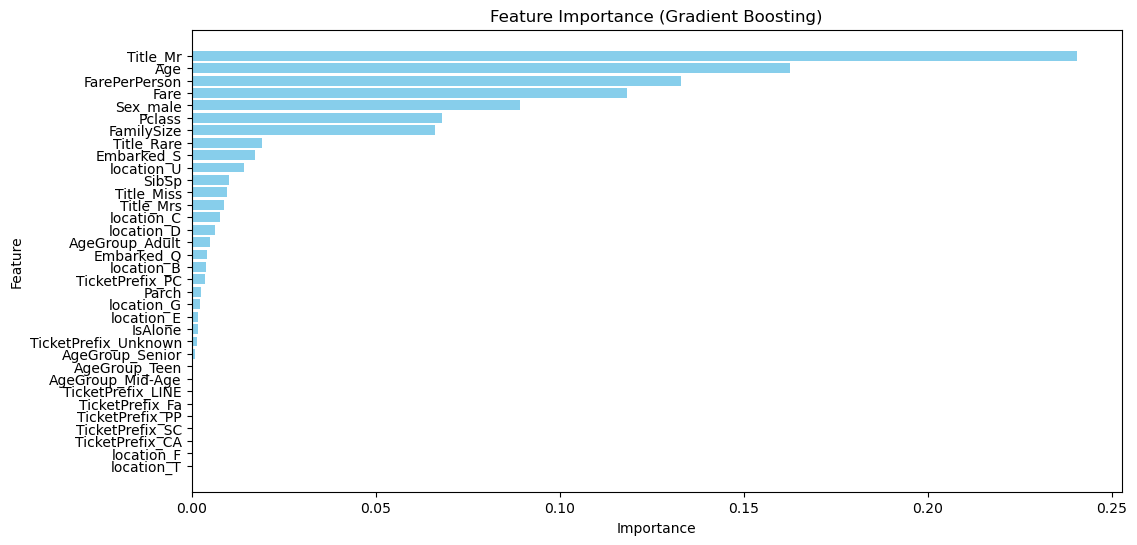

In [320]:
plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Gradient Boosting)')
plt.gca().invert_yaxis()  # Most important features at the top
plt.show()

In [321]:
importance_df[importance_df.Importance > ]

,Feature,Importance
20,Title_Mr,0.240655
1,Age,0.162569
7,FarePerPerson,0.132998
4,Fare,0.118299
8,Sex_male,0.089299
0,Pclass,0.068190
5,FamilySize,0.066152
22,Title_Rare,0.019242
10,Embarked_S,0.017121
18,location_U,0.014373


In [331]:
# Set importance threshold (e.g., keep features with importance > 0.01)
top_features = importance_df[importance_df['Importance'] > 0.02]['Feature'].tolist()
top_features

['Title_Mr',
 'Age',
 'FarePerPerson',
 'Fare',
 'Sex_male',
 'Pclass',
 'FamilySize']

### Retrain the model with selected features

In [412]:
X_train_selected = X_train[top_features]
X_test_selected = X_test[top_features]

In [413]:
# Train the first Gradient Boosting model
gb_model_retrained = GradientBoostingClassifier(random_state=RANDOM_STATE)
# Perform Grid Search
grid_search_retrained = GridSearchCV(gb_model_retrained, param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=1)
grid_search_retrained.fit(X_train_selected, y_train)

# Get the best model
best_gb_model_retrained = grid_search_retrained.best_estimator_

# Print best hyperparameters
print("Best Hyperparameters:", grid_search_retrained.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best Hyperparameters: {'learning_rate': 0.05, 'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.85}


In [414]:
# Train with the best parameters found
best_gb_model_retrained.fit(X_train_selected, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, random_state=17,
                           subsample=0.85)

In [415]:
evaluate_model(best_gb_model_retrained, X_train_selected, y_train)

{'Accuracy': 0.9405144694533762,
 'Precision': 0.9413814748195738,
 'Recall': 0.9405144694533762,
 'F1 Score': 0.9399959584797493}

In [417]:
evaluate_model(best_gb_model_retrained, X_test_selected, y_test)

{'Accuracy': 0.8576779026217228,
 'Precision': 0.8568237072080951,
 'Recall': 0.8576779026217228,
 'F1 Score': 0.8567922402192064}

# Predict on test data

In [445]:
test = pd.read_csv(r'test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [446]:
test_prep = prep_data(test)
test_prep.head()

,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,FarePerPerson,HasCabin,Sex_male,...,TicketPrefix_CA,TicketPrefix_LP,TicketPrefix_PC,TicketPrefix_PP,TicketPrefix_SC,TicketPrefix_Unknown,AgeGroup_Teen,AgeGroup_Adult,AgeGroup_Mid-Age,AgeGroup_Senior
0,0.873482,0.369741,-0.499470,-0.400248,-0.497811,-0.553443,1,-0.392588,0.0,True,...,False,False,False,False,False,True,False,True,False,False
1,0.873482,1.312974,0.616992,-0.400248,-0.512660,0.105643,0,-0.514205,0.0,False,...,False,False,False,False,False,True,False,False,True,False
2,-0.315819,2.444853,-0.499470,-0.400248,-0.464532,-0.553443,1,-0.340384,0.0,True,...,False,False,False,False,False,True,False,False,False,True
3,0.873482,-0.196199,-0.499470,-0.400248,-0.482888,-0.553443,1,-0.369179,0.0,True,...,False,False,False,False,False,True,False,True,False,False
4,0.873482,-0.573492,0.616992,0.619896,-0.417971,0.764728,0,-0.497467,0.0,False,...,False,False,False,False,False,True,False,True,False,False


In [447]:
# Generate predictions
y_pred_test = best_gb_model_retrained.predict(test_prep[top_features])
y_pred_proba_test = best_gb_model_retrained.predict_proba(test_prep[top_features])[:, 1] 


In [449]:
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': y_pred_test})
submission.to_csv('titanic_predictions.csv', index=False)